<a href="https://colab.research.google.com/github/ElvinSeAN/horse_racing_book/blob/main/Copy_of_PDP_horse_race_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gdaley_hkracing_path = kagglehub.dataset_download('gdaley/hkracing')

print('Data source import complete.')
print(gdaley_hkracing_path)

Data source import complete.
/kaggle/input/hkracing


## Importing Libraries

In [20]:
import numpy as np
import pandas as pd
import sklearn
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb

## Importing data

In [21]:
runs_data = pd.read_csv(gdaley_hkracing_path+"/runs.csv")
races_data = pd.read_csv(gdaley_hkracing_path+"/races.csv")
#removig unnessary columns
runs_data = runs_data[['result','horse_age', 'horse_country', 'horse_type', 'horse_rating', 'horse_id',
          'declared_weight', 'actual_weight', 'draw','win_odds','trainer_id', 'jockey_id', 'race_id']] #'place_odds', 'trainer_id', 'jockey_id', 'horse_no', 'horse_id'
# Group the sorted dataframe by horse_id (assuming horse_id identifies distinct horses clearly)
grouped = runs_data.groupby('horse_id')

# Add previous 1, 2, 3 race results for each horse using shift()
runs_data['prev_result_1'] = grouped['result'].shift(1)
runs_data['prev_result_2'] = grouped['result'].shift(2)
runs_data['prev_result_3'] = grouped['result'].shift(3)
runs_data[['prev_result_1', 'prev_result_2', 'prev_result_3']] = \
    runs_data[['prev_result_1', 'prev_result_2', 'prev_result_3']].fillna(99).astype(int)
# runs_data = pd.get_dummies(runs_data)
# print(pd.get_dummies(runs_data))

<ipython-input-21-68d079b6fef7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_data['prev_result_1'] = grouped['result'].shift(1)
<ipython-input-21-68d079b6fef7>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_data['prev_result_2'] = grouped['result'].shift(2)
<ipython-input-21-68d079b6fef7>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://panda

In [22]:
# print(races_data.columns)
races_data = races_data[['race_id', 'date', 'venue','config', 'surface', 'distance','going']]

print(races_data.columns)

Index(['race_id', 'date', 'venue', 'config', 'surface', 'distance', 'going'], dtype='object')


In [23]:
#Validating data types
for col in runs_data.columns:
    print(col, "-->" , runs_data[col].dtype, " | " , runs_data[col].unique())

result --> int64  |  [10  8  7  9  6  3 12  1 13 14  2  4 11  5]
horse_age --> int64  |  [ 3  2  4  5  6  7  8  9 10]
horse_country --> object  |  ['AUS' 'NZ' 'SAF' 'GB' 'USA' 'IRE' 'FR' 'CAN' nan 'ARG' 'GER' 'ZIM' 'JPN'
 'BRZ' 'GR' 'ITY' 'SPA']
horse_type --> object  |  ['Gelding' 'Mare' 'Horse' 'Brown' 'Rig' 'Colt' nan 'Roan' 'Filly' 'Grey']
horse_rating --> int64  |  [ 60  52  80 100  79  77  75  73  70  68  49  63  58  59  50  71  48  65
  47  72  69  76  87  66  91  51  82  64  96  55  67  62 103  54 109  61
  86  84 122  85  57  53  43  56  41  40  46  78  81  89  38  45  39  83
  74  93  44  88  95  98 106 125  94  92  97 104  99  90 105 112 107  42
  37  36  33  35  34 108  32  28  23 111  31 116 113  30  18  27 118  24
  26 120 101 102 124  19  20 114 128  25 119  29 110  21 117 130 126 115
  22 121 129  16  17 133 123  15 134 132 127 131 138  13  10  11 136]
horse_id --> int64  |  [3917 2157  858 ... 2606 2093  216]
declared_weight --> float64  |  [1020.          980.        

In [24]:
runs_data = pd.merge(runs_data, races_data, on='race_id', how='left', suffixes=('', '_race'))


In [25]:
#Checking nulls
runs_data.isna().sum()

,0
result,0
horse_age,0
horse_country,2
horse_type,2
horse_rating,0
horse_id,0
declared_weight,0
actual_weight,0
draw,0
win_odds,0


In [26]:
#Checking rows with null data
runs_data.loc[runs_data['horse_country'].isna()==True]

,result,horse_age,horse_country,horse_type,horse_rating,horse_id,declared_weight,actual_weight,draw,win_odds,...,race_id,prev_result_1,prev_result_2,prev_result_3,date,venue,config,surface,distance,going
182,5,3,NaN,NaN,60,2645,1107.0,120,12,28.0,...,13,99,99,99,1997-06-04,HV,A,0,1000,GOOD TO FIRM
846,11,3,NaN,NaN,60,2645,1105.0,119,1,14.0,...,69,5,99,99,1997-06-25,HV,C,0,1200,GOOD


In [27]:
#Dropping rows with nulls as they do not contribute to correct class
runs_data.dropna(inplace=True, axis=0)

#Converting categorical data
runs_data = pd.get_dummies(runs_data)

### Creating data for training and testing

In [28]:
X = runs_data.drop("result", axis=1)
y = runs_data['result']

#This is to avoid labelling error with XGBOOST
le = LabelEncoder()
y = le.fit_transform(y)

#For binary classification task, using first 3 ranks as correct class to imporve inblance in comparison if used just 1st horse.

y = np.where(y<=3, 1, 0)
for col in ['prev_result_1', 'prev_result_2', 'prev_result_3']:
    X[col] = np.where(X[col] <= 3, 1, 0)  # Top 3 finishers labeled as 1, others as 0


#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=90, stratify=y)

In [29]:
#Checking correct label distribution in both training and test datasets
for i in [y_test, y_train]:
    print( sum(i)/len(i))

0.3201586002895085
0.32012713197809806


## Getting Model

In [30]:
#Defining function to print out metrics
def model_metrics(model, X_data, y_data):
    y_preds = model.predict(X_data)
    print('Accuracy: ', sklearn.metrics.accuracy_score(y_test, y_preds),
          'f1_score: ', sklearn.metrics.f1_score(y_test, y_preds, average=None))
    print('confusion matrix: ', '\n', sklearn.metrics.confusion_matrix(y_test, y_preds))

In [31]:
ratio = (len(y_train) - np.sum(y_train)) / np.sum(y_train)
print(len(y_train), np.sum(y_train))
print(ratio)

63556 20346
2.1237589698220782


### Running Hyperparameter Tuning for XGBoost Model

In [32]:
!pip install optuna


In [33]:
from sklearn.metrics import roc_auc_score
import optuna


In [34]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'tree_method': 'hist',
        'device': 'cuda',
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', ratio * 0.1, ratio * 2.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'early_stopping_rounds':10,
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)

    preds = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, preds)

    return auc


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Number of trials can be configured

print('Best trial:', study.best_trial.params)


[I 2025-04-05 04:20:02,543] A new study created in memory with name: no-name-edf33755-419c-44a2-94e7-cc1c96189bf2
[I 2025-04-05 04:20:04,599] Trial 0 finished with value: 0.7515098333252471 and parameters: {'max_depth': 3, 'learning_rate': 0.18231860513550754, 'scale_pos_weight': 3.352511790168326, 'gamma': 0.6354123464754193, 'subsample': 0.9365763737259101, 'colsample_bytree': 0.5712815911495386, 'reg_lambda': 2.51612267280082}. Best is trial 0 with value: 0.7515098333252471.
[I 2025-04-05 04:20:07,374] Trial 1 finished with value: 0.7589410831789772 and parameters: {'max_depth': 6, 'learning_rate': 0.12205094484894359, 'scale_pos_weight': 2.271638755281364, 'gamma': 0.7194192707083469, 'subsample': 0.9081533590469644, 'colsample_bytree': 0.8062725656517766, 'reg_lambda': 8.703906884198599}. Best is trial 1 with value: 0.7589410831789772.
[I 2025-04-05 04:20:10,804] Trial 2 finished with value: 0.7570862347859703 and parameters: {'max_depth': 6, 'learning_rate': 0.11949349203182669, 

Best trial: {'max_depth': 4, 'learning_rate': 0.08441360953620274, 'scale_pos_weight': 0.872053489656357, 'gamma': 0.02516554467903187, 'subsample': 0.9944454842660557, 'colsample_bytree': 0.9358134546402868, 'reg_lambda': 4.8974423934549876}


Accuracy:  0.7285543457738057 f1_score:  [0.81987889 0.44938082]
confusion matrix:  
 [[9816  986]
 [3327 1760]]


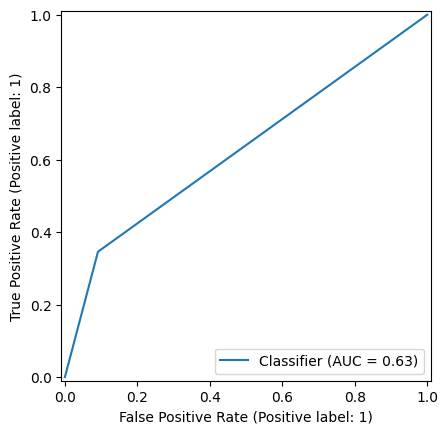

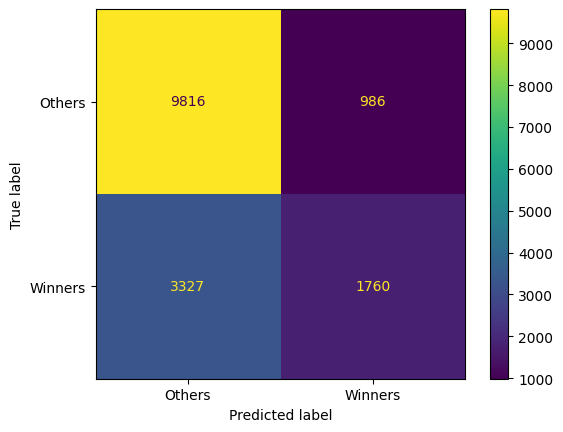

In [35]:
xg_model = model = xgb.XGBClassifier(**study.best_trial.params
                         )
xg_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
y_preds = xg_model.predict(X_test)

model_metrics(xg_model, X_test, y_test)
sklearn.metrics.RocCurveDisplay.from_predictions(y_test, y_preds)
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(xg_model, X_test, y_test, display_labels=['Others', 'Winners'])

In [36]:
best_params = study.best_trial.params.copy()
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'tree_method': 'hist',
    'device': 'cuda'
})

# Retrain final model explicitly again clearly right here:
final_model = xgb.XGBClassifier(**best_params)
final_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

# Predict explicitly:
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Explicit Threshold optimization here practically clearly:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

thresholds = np.linspace(0.7, 0.99, 100)
f1_scores = [f1_score(y_test, y_pred_proba >= thr) for thr in thresholds]

optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Post Optimal classification threshold: {optimal_threshold:.3f}")

# Predict explicitly practically again practically:
y_optimized = (y_pred_proba >= optimal_threshold).astype(int)

# Practically clearly evaluated results here explicitly shown practically:
print("Post Optimized Accuracy:", accuracy_score(y_test, y_optimized))
print("Post Optimized F1-Score:", f1_score(y_test, y_optimized))
print("Confusion Matrix explicitly shown:\n", confusion_matrix(y_test, y_optimized))



Post Optimal classification threshold: 0.700
Post Optimized Accuracy: 0.6980300837057084
Post Optimized F1-Score: 0.13424756405629737
Confusion Matrix explicitly shown:
 [[10719    83]
 [ 4715   372]]


In [21]:
#1st run {'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 2, 'reg_lambda': 5.0, 'scale_pos_weight': 5}
#2nd run {'learning_rate': 0.1, 'scale_pos_weight': 5}
ratio = (len(y_train) - np.sum(y_train)) / np.sum(y_train)

# param_grid = {
#     'learning_rate':[0.1,0.15],
#     'scale_pos_weight':[5,6]
# }
param_grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.15],  # Cover more ranges, especially lower ones
    'scale_pos_weight': [ratio * x for x in [0.1, 0.3, 0.6, 0.8, 1, 1.5, 2]],  # Broader weight range
    'max_depth': [3, 4, 5, 6],  # Automate depth exploration too
    'gamma': [0, 0.1, 0.25, 0.5],  # Gamma matters a lot for complexity
    'subsample': [0.6, 0.7, 0.8, 0.9],  # sample rate
    'colsample_bytree': [0.5, 0.7, 0.9],  # features sampled per tree
    'reg_lambda': [1, 3, 5, 10]  # L2 regularization
}

model = xgb.XGBClassifier(objective='binary:logistic',
                          # max_depth=4,
                          # gamma=0.25,
                          # reg_lambda=5,
                          # subsample=0.9,
                          # colsample_bytree=0.5,
                          early_stopping_rounds=10,
                          tree_method = "hist", device = "cuda",
                          eval_metric='auc'
                         )

# optimal_params = sklearn.model_selection.GridSearchCV(estimator=model,
#                              param_grid=param_grid,
#                              scoring='roc_auc', cv=3, n_jobs=10)
optimal_params = sklearn.model_selection.GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=['roc_auc', 'precision', 'recall', 'f1'],
    # scoring='f1',
    cv=3,
    refit='roc_auc',  # main selection metric
    n_jobs=10
)

optimal_params.fit(X_train,
                   y_train,
                   eval_set=[(X_test, y_test)], verbose=True)
print(optimal_params.best_params_)

KeyboardInterrupt: 

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:58:15] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:58:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy:  0.6858203788784694 f1_score:  [0.76993271 0.5047619 ]
confusion matrix:  
 [[8353 3723]
 [1269 2544]]


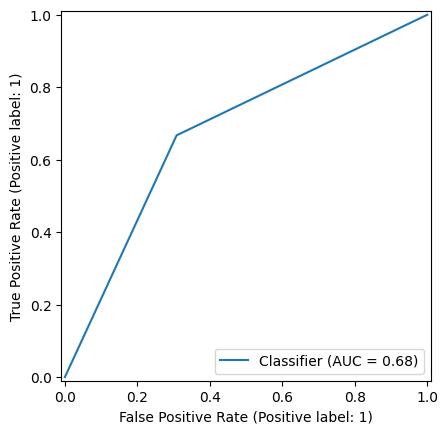

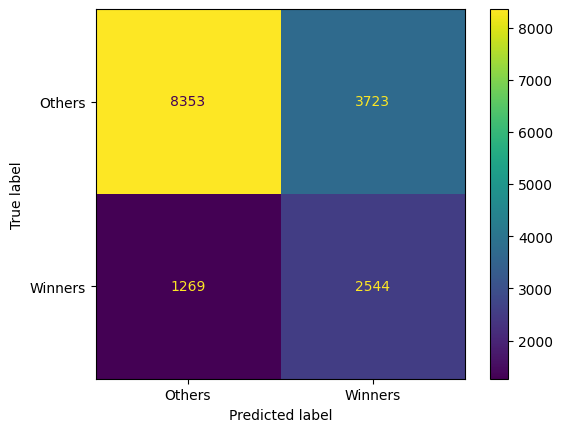

In [ ]:
# Previous: confusion matrix:
#  [[11515   561]
#  [ 2901   912]]

xg_model = model = xgb.XGBClassifier(objective='binary:logistic',
                          max_depth=4,
                          learning_rate=optimal_params.best_params_['learning_rate'],
                          scale_pos_weight=optimal_params.best_params_['scale_pos_weight'],       #adds weights to correct class and wrong class
                          gamma=0.25,
                          reg_lambda=5,
                          subsample=0.9,
                          colsample_bytree=0.5,    #percentage of columns selected, helps with fit
                          early_stopping_rounds=10,
                          tree_method = "hist", device = "cuda",
                          eval_metric='auc'
                         )
xg_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=0)
y_preds = xg_model.predict(X_test)

model_metrics(xg_model, X_test, y_test)
sklearn.metrics.RocCurveDisplay.from_predictions(y_test, y_preds)
sklearn.metrics.ConfusionMatrixDisplay.from_estimator(xg_model, X_test, y_test, display_labels=['Others', 'Winners'])

<Axes: >

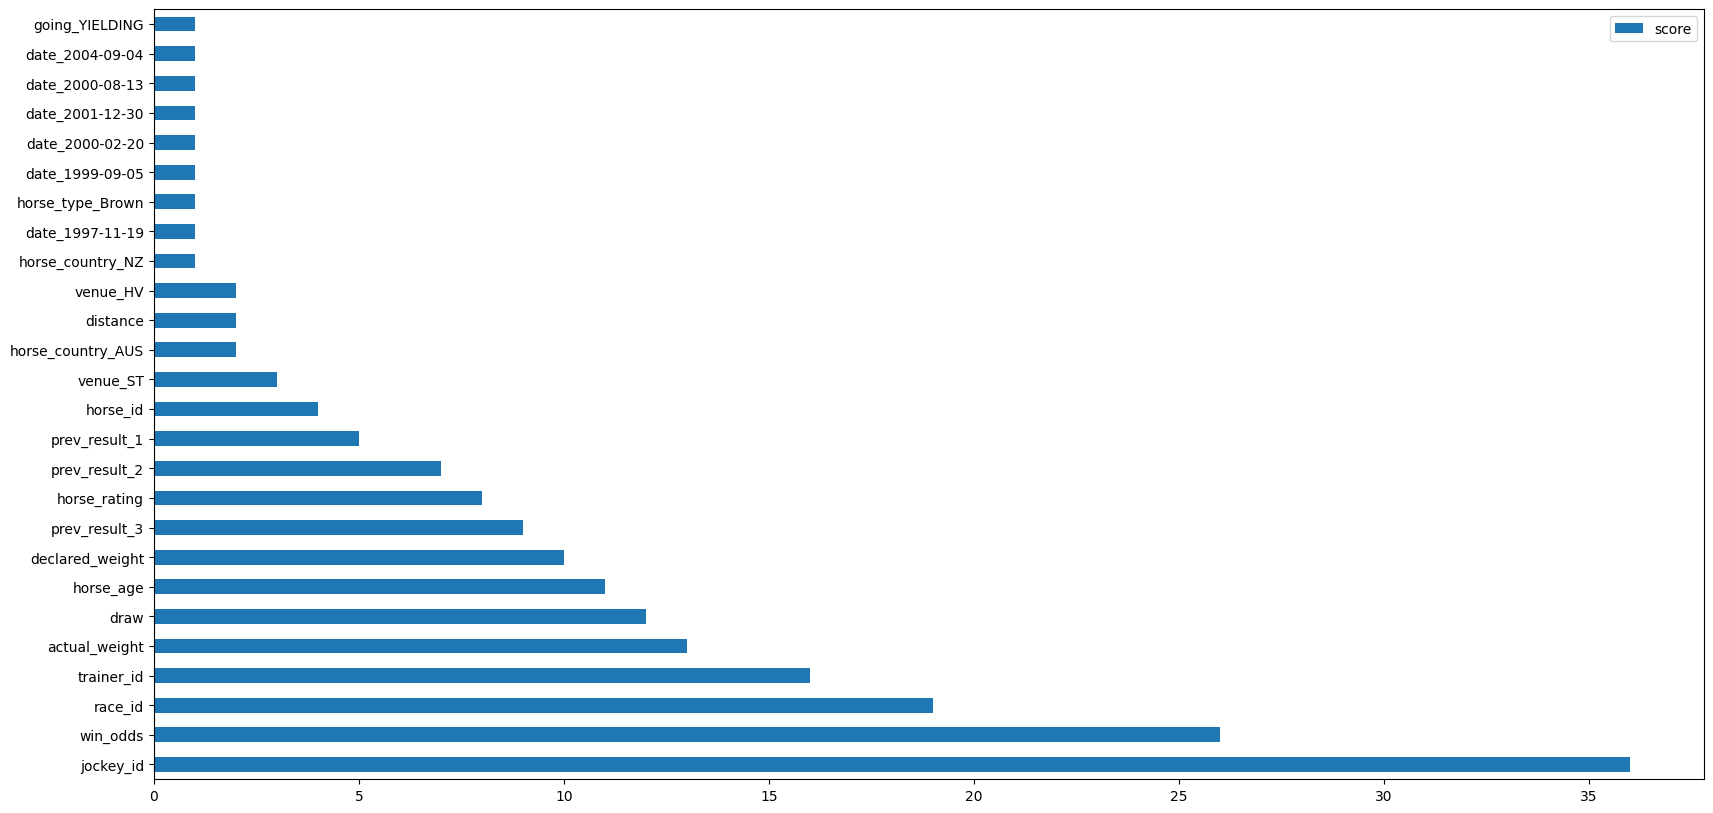

In [ ]:
feature_important = xg_model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10))

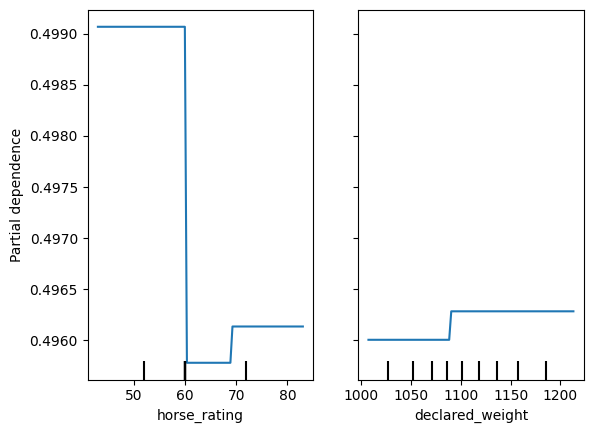

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(xg_model, X_test, features=['horse_rating', 'declared_weight'])

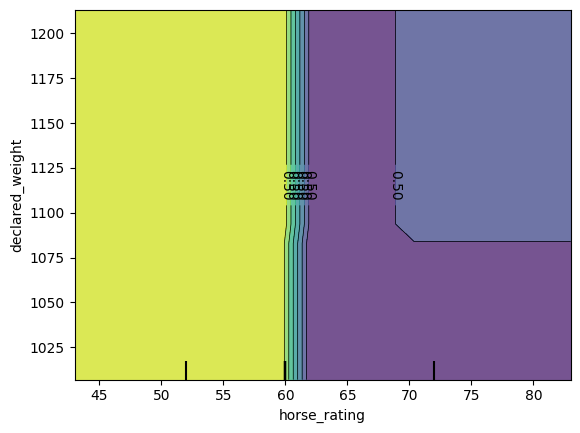

In [ ]:
PartialDependenceDisplay.from_estimator(xg_model, X_test, features=[('horse_rating', 'declared_weight')],grid_resolution=20)

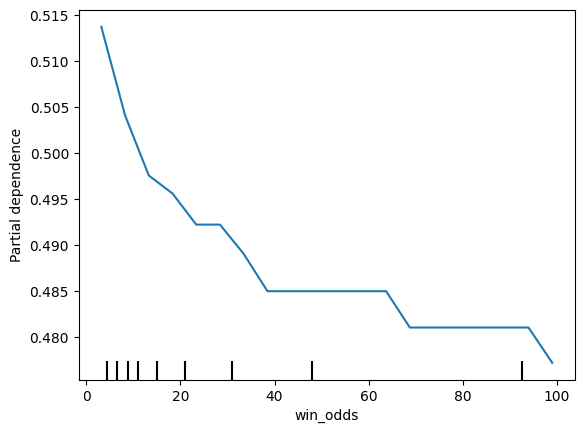

In [ ]:
PartialDependenceDisplay.from_estimator(xg_model, X_test, features=['win_odds'],grid_resolution=20)

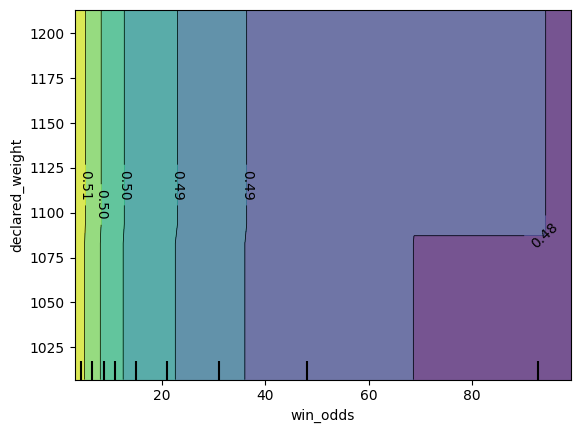

In [ ]:
PartialDependenceDisplay.from_estimator(xg_model, X_test, features=[('win_odds', 'declared_weight')],grid_resolution=20)